# 04.2 Working Geospatial Data: Raster Data 2: Joint Land Use and Elevation

In this notebook we will continue examining using Python for analyzing 

## Imports and data paths

Load the scientific Python stack, bring in the NLCD color helper from `pygeohydro`, and define file locations for the DEM, land-cover raster, and class lookup table.

In [1]:
import numpy as np
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import pygeohydro as gh

elev_fname = '../data/ubrb_dem_30m.tif'
lulc_fname = '../data/upper_boise_landcover_30m.tif'

nlcd_cfile = './nlcd_classifications.csv'  # Lookup table linking NLCD codes to human-readable labels


## Mask elevations within a target band

This helper returns a masked array that keeps only elevations inside a specified range so downstream plots can focus on a slice of terrain.

In [2]:
def z_in_range(z_array, zmin, zmax):
    """Mask elevations outside [zmin, zmax] so downstream code works on a focused slice."""
    return np.ma.masked_outside(z_array, zmin, zmax)


## Count land-cover classes in that band

Given the elevation mask, tally how many pixels of each NLCD category fall inside the slice for later normalization.

In [3]:
def lulc_in_zrange(lulc_array_local, z_ma_local, lulc_bins_local):
    """Count how many pixels of each NLCD class fall inside the elevation mask."""
    # Mask out cells outside the target elevation band
    lulc_ma = np.ma.masked_array(lulc_array_local, ~z_ma_local.mask)

    # Flatten valid land-cover values and count occurrences per NLCD code
    lulc_1d = lulc_ma.data[lulc_ma.mask]
    lulc_counts = np.zeros(lulc_bins_local.size)

    for i in np.arange(lulc_bins_local.size):
        lulc_counts[i] = np.count_nonzero(lulc_1d == lulc_bins_local[i])

    return lulc_counts


## Load rasters and summarize elevations

Open the DEM, compute basin-wide elevation stats, and print them for quick reference before filtering by range.

In [4]:
# Open the DEM and compute high-level elevation stats for context
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

zmin = elev_array.min()
zmax = elev_array.max()
zmean = elev_array.mean()

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)



Elevation Statistics:
Number of columns [east-west]: 5433 
Number of rows [north-south]: 3239
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 1797.45 m



## Inspect land-cover codes

Load the NLCD raster, orient it for display, and list the unique class IDs present in the study area.

In [5]:
# Load the land-cover raster and align it so north points up in plots
lulc_data = rio.open(lulc_fname)
lulc_array = np.flipud(lulc_data.read(1))

# Identify the NLCD class codes present inside the basin
lulc_bins = np.unique(lulc_array)

lulcstats = f'''
Land Use/Land Cover Present: {lulc_bins}
'''

print(lulcstats)



Land Use/Land Cover Present: [11 12 21 22 23 24 31 41 42 43 52 71 81 82 90 95]



## Focus on the mid-elevation band

Select elevations within ±250 m of the basin mean so we can compare land-cover types in a representative portion of the watershed.

In [6]:
# Define the elevation window centered on the mean (±250 m)
zmin_hist = zmean - 250.0
zmax_hist = zmean + 250.0

# Produce a masked DEM retaining only cells inside the elevation window
z_mid_ma = z_in_range(elev_array, zmin_hist, zmax_hist)


## Map the mid-elevation DEM slice

Visualize the masked DEM to confirm which areas fall within ±250 m of the mean elevation.

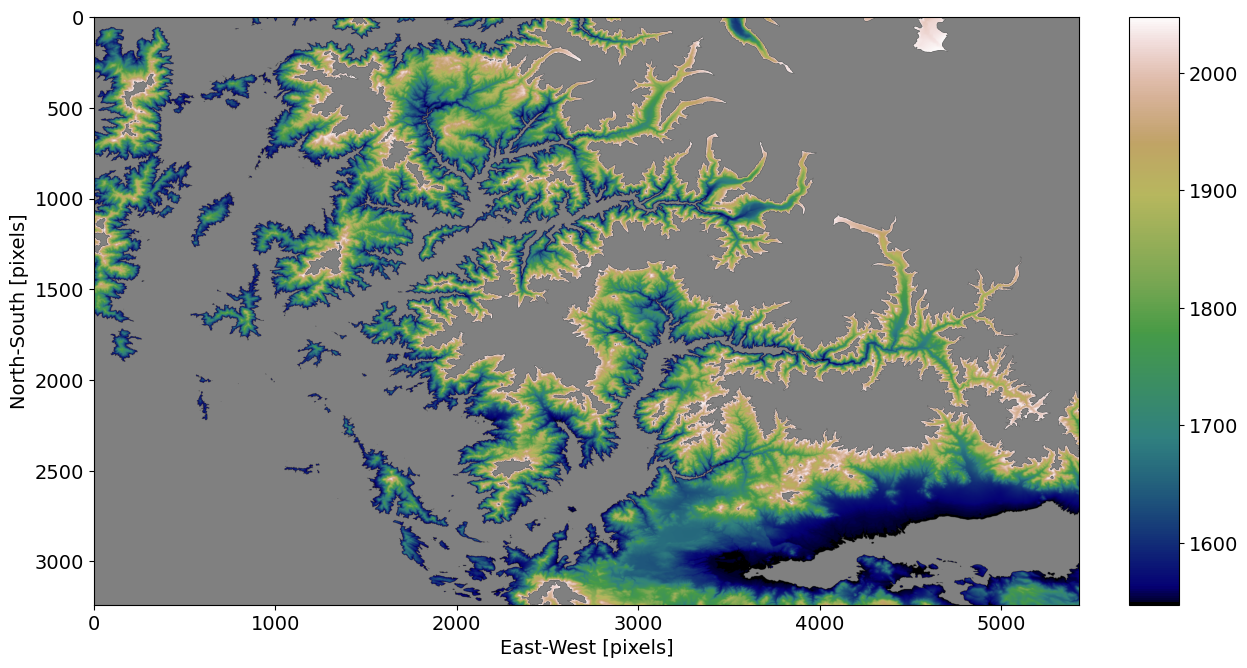

In [7]:
plt.rcParams.update({'font.size': 14})  # Improve readability of the map
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(z_mid_ma, cmap='gist_earth')
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)  # Place colorbar just outside the axes
cax = divider.new_horizontal(size='5%', pad=0.5, pack_start=False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Visualize land cover within the elevation slice

Mask the land-cover grid using the same elevation filter and apply the NLCD legend so we can see which categories dominate.

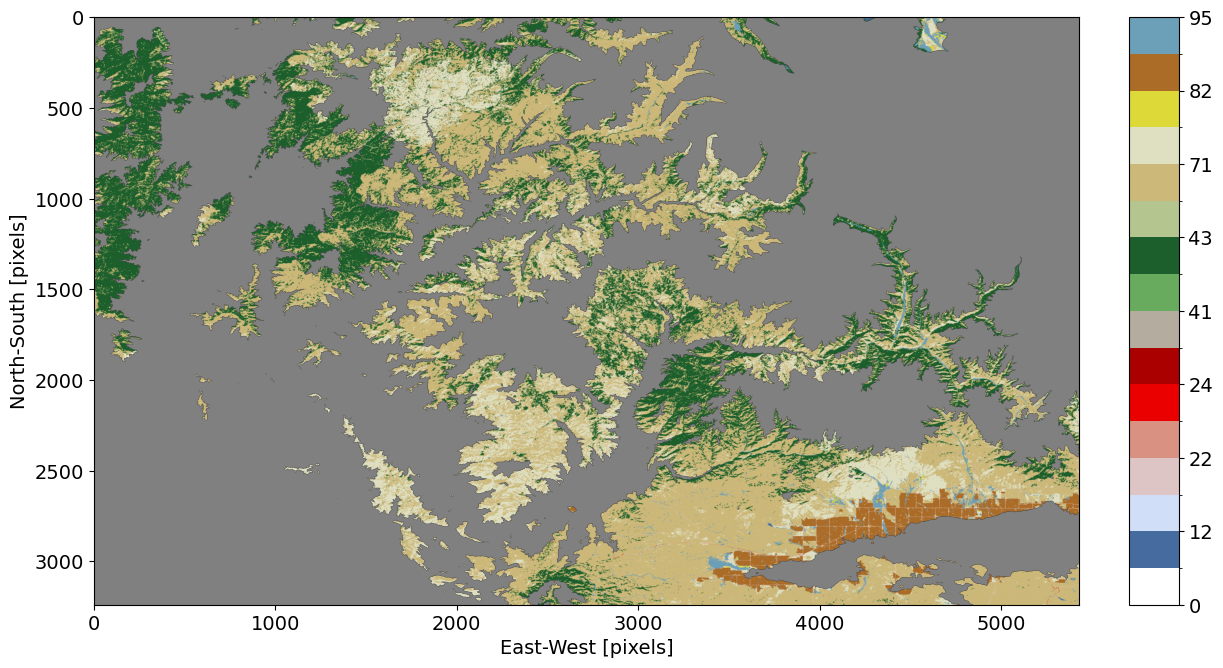

In [8]:
# Mask the land-cover raster with the same elevation filter
lulc_mid = np.ma.masked_array(lulc_array, z_mid_ma.mask)

# Use pygeohydro to retrieve the standard NLCD colormap
cmap_nlcd, norm_nlcd, levels = gh.plot.cover_legends()

# Associate NLCD codes with labels from the lookup table
nlcd_df = pd.read_csv(nlcd_cfile)

# cmap_nlcd = mcolors.ListedColormap(nlcd_df.color_code.values.astype(str),'nlcd_cmap')
# norm_nlcd = mcolors.BoundaryNorm(lulc_bins, cmap_nlcd.N)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(lulc_mid, cmap=cmap_nlcd, norm=norm_nlcd)
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size='5%', pad=0.5, pack_start=False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


## Summarize land-cover frequencies

Collapse the masked land-cover raster into raw counts and normalized frequencies for plotting.

In [9]:
# Count NLCD classes inside the elevation slice and normalize to fractions
lulc_mid_counts = lulc_in_zrange(lulc_array, z_mid_ma, lulc_bins)

lulc_mid_freq = lulc_mid_counts / lulc_mid_counts.sum()


## Compare category proportions

Display the land-cover mix in two complementary styles: a standard bar chart using class labels and a stacked bar that highlights how the slice breaks down across NLCD classes.

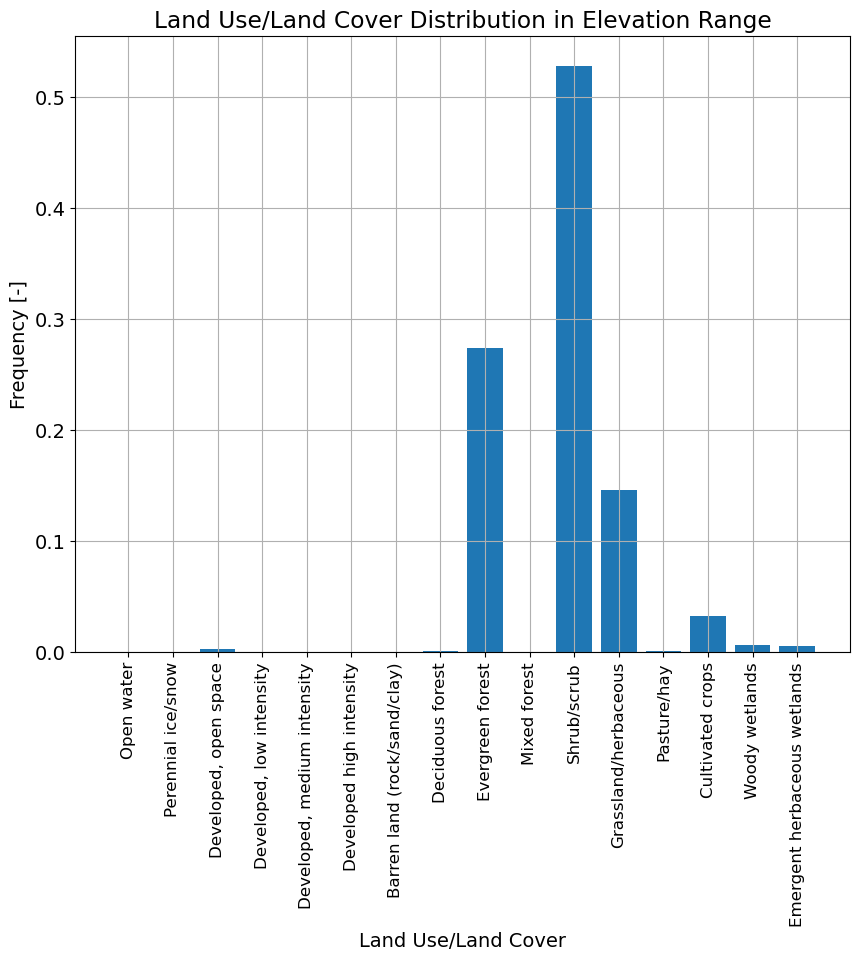

In [10]:
# Standard bar chart comparing relative frequencies by NLCD code
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(lulc_bins.astype(str), lulc_mid_freq)
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Land Use/Land Cover')
ax.set_ylabel('Frequency [-]')
ax.set_xticks(nlcd_df.id.astype(str))
ax.set_xticklabels(nlcd_df.label_short.values, rotation=90, fontsize=12)
ax.grid('on')
plt.show()


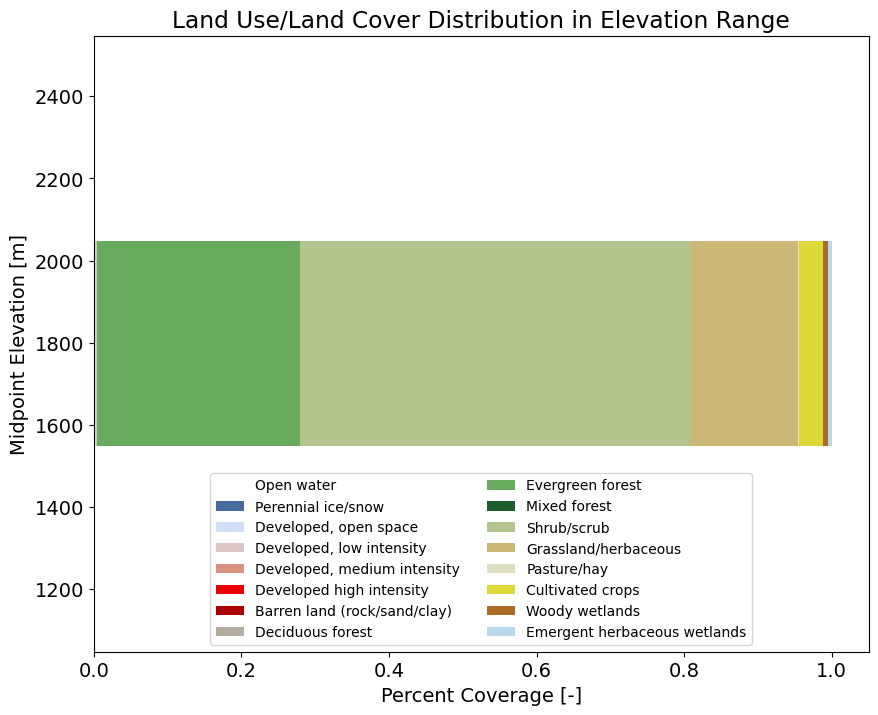

In [11]:
# Stacked horizontal bar emphasizing how the elevation band partitions among NLCD classes
fig, ax = plt.subplots(figsize=(10,8))

left = 0.0

for i in np.arange(lulc_bins.size):
    ax.barh(zmean, lulc_mid_freq[i], left=left, height=500.0, color=cmap_nlcd.colors[i], label=nlcd_df.label_short.values[i])
    left += lulc_mid_freq[i]

ax.set_ylim([zmean - 750.0, zmean + 750.0])
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Percent Coverage [-]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('Midpoint Elevation [m]')
ax.legend(fontsize=10, ncol=2, loc='lower center')
plt.show()


## Wrap-up

The mid-elevation slice highlights how NLCD classes cluster around the basin mean elevation. Adjust the elevation window or swap in another watershed to see how land-cover composition shifts with topography.